# Исследование объявлений о продаже квартир

Задача: научиться определять рыночную стоимость объектов недвижимости на основе архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.
Необходимо провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

Исходные данные: Архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Загружаем файл с исходными данными и изучаем общую информацию

Импортируем библиотеку pandas, открываем csv с разделителем '\t'.
Выводим первые 5 строк датафрейма.
Выводим общую информацию о датафрейме.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
display(df.head())
df.info()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Из вывода датасета видим, что есть незаполненные поля:
- ceiling_height, floors_total, living_area, is_apartment, kitchen_area, balkony, locality_name, airports_nearest,
- cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition

Строим гистограмму для всех числовых полей и смотрим на распределение величин

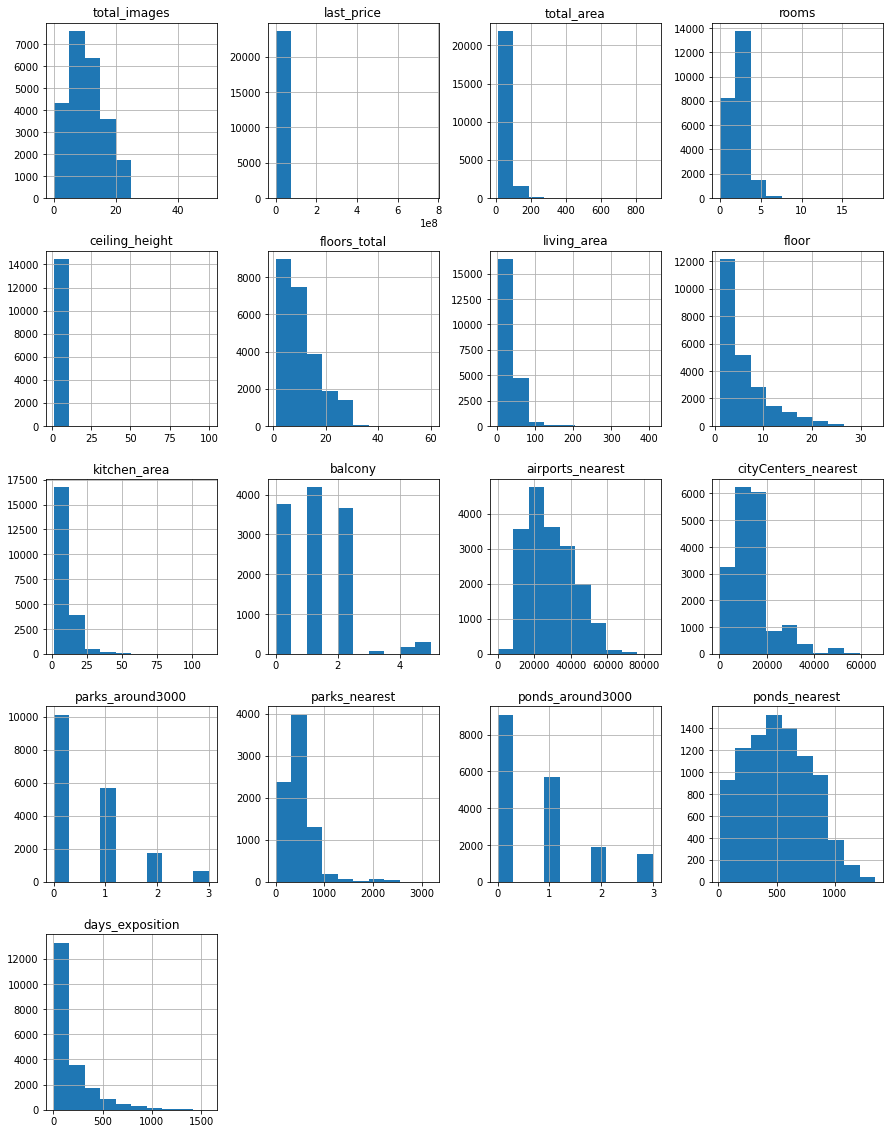

In [3]:
df.hist(figsize=(15, 20));

### Выполняем предобработку данных

Определяем столбцы с пропусками:

In [4]:
print(df.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Пропуски обнаружились в следующих столбцах:
- ceiling_height, living_area, kitchen_area: возможно, значения этих показателей не очень привлекательны (маленькие), поэтому владельцы решили не отпугивать клиентов сразу, а дождаться первых звонков для уточнения данных. Также возможен вариант, что многие просто не знают этих величин или лениво было найти/запросить документы БТИ.
- is_apartment: скорее всего, люди не стали заполнять это поле, потому что продают не апартаменты.
- floors_total: отсутствующих значений мало, так что предположим, что забыли указать. Заполним этот параметр значением из поля floor, потому что дом уж точно этажностью не ниже этажа продаваемой квартиры.
- balcony: возможно, люди решили, что заполнять поля по отсутствующим объектам необязательно (можно с ними согласиться).
- airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest: это вычисляемые с помощью геосервисов параметры. Возможно, их просто забыли вычислить.
- days_exposition: отсутствует дата размещения объявления, так как объявление еще не снято с публикации.
- locality_name: думаю, что большинство таких квартир находятся в Санкт-Петербурге, поэтому люди не стали заполнять. Удалим эти значения.
- airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest - поля, которые заполнялись на основе анализа картографических данных, оставим их без изменений.

Заменяем пропущенные значения в следующих столбцах:
- balcony - меняем на 0,
- is_apartment - меняем на 0 (не апартаменты).

Высоту потолков и площадь кухни заполним медианными значениями.

Для заполнения жилой площади вычислим медианное значение, сколько она в % составляет от общей площади квартиры.

Удаляем строки с пустыми значениями в поле locality_name.

In [5]:
df['balcony']=df['balcony'].fillna(0)
df['floors_total']=df['floors_total'].fillna(df['floor'])
df['is_apartment']=df['is_apartment'].fillna(0)
df['ceiling_height']=df['ceiling_height'].fillna(df['ceiling_height'].median())
df['kitchen_area']=df['kitchen_area'].fillna(df['kitchen_area'].median())
df['living_area']=df['living_area'].fillna(df['total_area']*(df['living_area']/df['total_area']).median())
df.dropna(axis='index', subset=['locality_name'], inplace=True)
display(df.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

Рассматриваем типы данных в каждом столбце:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23650 non-null  int64  
 1   last_price            23650 non-null  float64
 2   total_area            23650 non-null  float64
 3   first_day_exposition  23650 non-null  object 
 4   rooms                 23650 non-null  int64  
 5   ceiling_height        23650 non-null  float64
 6   floors_total          23650 non-null  float64
 7   living_area           23650 non-null  float64
 8   floor                 23650 non-null  int64  
 9   is_apartment          23650 non-null  object 
 10  studio                23650 non-null  bool   
 11  open_plan             23650 non-null  bool   
 12  kitchen_area          23650 non-null  float64
 13  balcony               23650 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Поля с ошибочными типами данных:
- first_day_exposition - дата публикации, д.б. timestamp, для корректного преобразования поля дополнительно проверим формат записи даты и времени,
- is_apartment - признак апартаментов, д.б. bool,
- floors_total - количество этажей в доме, д.б. int64,
- balcony - количество балконов, д.б. int64,
- days_exposition - количество дней размещения объявления, д.б. int64.
Преобразуем типы данных в выбранных столбцах на указанные и проверяем изменения:

In [7]:
df[['balcony','floors_total']] = df[['balcony','floors_total']].astype(int)
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
df['is_apartment'] = df['is_apartment'].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23650 non-null  int64         
 1   last_price            23650 non-null  float64       
 2   total_area            23650 non-null  float64       
 3   first_day_exposition  23650 non-null  datetime64[ns]
 4   rooms                 23650 non-null  int64         
 5   ceiling_height        23650 non-null  float64       
 6   floors_total          23650 non-null  int64         
 7   living_area           23650 non-null  float64       
 8   floor                 23650 non-null  int64         
 9   is_apartment          23650 non-null  bool          
 10  studio                23650 non-null  bool          
 11  open_plan             23650 non-null  bool          
 12  kitchen_area          23650 non-null  float64       
 13  balcony         

Проверяем уникальные значения в столбце со строковыми значениями 'locality_name', для этого отсортируем его по алфавиту:

In [8]:
display(df['locality_name'].sort_values().unique())

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Создаем новый столбец, в котором устраним неявные дубликаты:

In [9]:
df['locality_name_new'] = (
    df['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок', 'поселок при железнодорожной станции', 'поселок станции'], 'поселок', regex=True)
    .replace('садоводческое некоммерческое товарищество', 'садовое товарищество', regex=True)
)
display(df['locality_name_new'].sort_values().unique())

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалево',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'деревня Агалатово', 'деревня Аро', 'деревня Батово',
       'деревня Бегуницы', 'деревня Белогорка', 'деревня Большая Вруда',
       'деревня Большая Пустомержа', 'деревня Большие Колпаны',
       'деревня Большое Рейзино', 'деревня Большой Сабск', 'деревня Бор',
       'деревня Борисова Грива', 'деревня Ваганово', 'деревня Вартемяги',
       'деревня Вахнова Кара', 'деревня Выскатка

Вычислим, сколько значений было до замены и сколько стало после:

In [10]:
print('Значений было до замены:', len(df['locality_name'].unique()))
print('Значений стало после замены:', len(df['locality_name_new'].unique()))

Значений было до замены: 364
Значений стало после замены: 319


### Добавляем в таблицу новые столбцы

Рассмотрим детально значения в колонках.
Для этого построим гистограммы hist(), таблицу статистики describe().
Количество корзин  для гистограммы увеличим, чтобы были видны значения.

Добавляем новые столбцы в датафрейм.
1. Цена одного квадратного метра.

In [11]:
print(len(df.query('total_area==0.0')))

0


0-х значений в поле с общей площадью нет, поэтому можно не бояться деления на 0.

In [12]:
df['sq_m_price']=df[['last_price','total_area']].apply(lambda x: round(x['last_price']/x['total_area'],2), axis=1)
print(df['sq_m_price'])

0        120370.37
1         82920.79
2         92785.71
3        408176.10
4        100000.00
           ...    
23694     72490.85
23695     52542.37
23696     44091.71
23697    149511.40
23698     41795.67
Name: sq_m_price, Length: 23650, dtype: float64


2. День недели публикации объявления (0 — понедельник, 1 — вторник и так далее).

In [13]:
df['day']=df['first_day_exposition'].dt.dayofweek
print(df['day'].value_counts().sort_index())

0    3606
1    4175
2    3966
3    4286
4    3992
5    1933
6    1692
Name: day, dtype: int64


3. Месяц публикации объявления.

In [14]:
df['month']=df['first_day_exposition'].dt.month
print(df['month'].value_counts().sort_index())

1     1491
2     2639
3     2582
4     2373
5     1270
6     1755
7     1690
8     1742
9     1979
10    2124
11    2367
12    1638
Name: month, dtype: int64


4. Год публикации объявления.

In [15]:
df['year']=df['first_day_exposition'].dt.year
print(df['year'].value_counts().sort_index())

2014     136
2015    1173
2016    2765
2017    8185
2018    8512
2019    2879
Name: year, dtype: int64


5. Тип этажа квартиры (значения — «первый», «последний», «другой»):

In [16]:
def floor_cat(x):
    if x['floor']==1:
        return "первый"
    elif x['floor']!=1 and x['floor']==x['floors_total']:
        return "последний"
    else:
        return "другой"  
df['floor_cat']=df[['floor','floors_total']].apply(floor_cat, axis=1)
print(df['floor_cat'].value_counts())

другой       17326
последний     3412
первый        2912
Name: floor_cat, dtype: int64


6. Расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).

In [17]:
df['cityCenters_nearest_km']=round(df['cityCenters_nearest']/1000,0)
print(df['cityCenters_nearest_km'])

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
23694     4.0
23695     NaN
23696     NaN
23697    10.0
23698     NaN
Name: cityCenters_nearest_km, Length: 23650, dtype: float64


Проверяем, что получилось:

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23650 non-null  int64         
 1   last_price              23650 non-null  float64       
 2   total_area              23650 non-null  float64       
 3   first_day_exposition    23650 non-null  datetime64[ns]
 4   rooms                   23650 non-null  int64         
 5   ceiling_height          23650 non-null  float64       
 6   floors_total            23650 non-null  int64         
 7   living_area             23650 non-null  float64       
 8   floor                   23650 non-null  int64         
 9   is_apartment            23650 non-null  bool          
 10  studio                  23650 non-null  bool          
 11  open_plan               23650 non-null  bool          
 12  kitchen_area            23650 non-null  float6

### Проведем исследовательский анализ данных

In [19]:
#общая площадь
print(df['total_area'].sort_values())
print()
print(df['total_area'].describe())

19904     12.0
19807     13.0
17961     13.0
19546     13.0
19558     13.2
         ...  
5358     590.0
15651    618.0
3117     631.0
12859    631.2
19540    900.0
Name: total_area, Length: 23650, dtype: float64

count    23650.000000
mean        60.329069
std         35.661808
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64


Text(0.5, 1.0, 'Распределение общей площади')

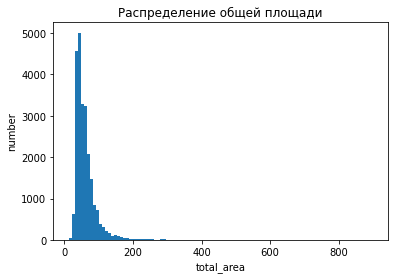

In [20]:
df['total_area'].plot(kind='hist', bins=100)
plt.xlabel('total_area')
plt.ylabel('number')
plt.title('Распределение общей площади')

Из статистики и гистограммы видно, что основной массив данных укладывается в показатели от 12 кв.м до 200 кв.м. 
Количество записей для квартир, площадь которых больше 200 кв.м., равно 227, то есть 227/23699 = 0,96 % от общего количества записей. Сделаем срезом данных, где общая площадь (total_area) будет меньше или равна 200 кв.м, чтобы получить нормальное распределение объявлений.

227

count    23423.000000
mean        58.155492
std         26.518218
min         12.000000
25%         40.000000
50%         51.800000
75%         68.800000
max        200.000000
Name: total_area, dtype: float64


Text(0.5, 1.0, 'Распределение общей площади <200кв.м')

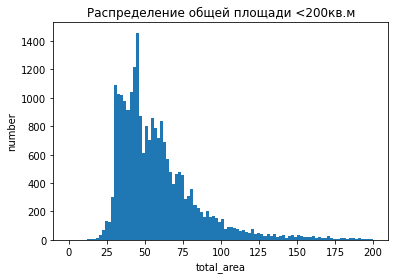

In [21]:
print(len(df.query('total_area>200')))
print()
print(df.query('total_area<=200')['total_area'].describe())
df.query('total_area<=200')['total_area'].plot(kind='hist', bins=100, range=(0,200))
plt.xlabel('total_area')
plt.ylabel('number')
plt.title('Распределение общей площади <200кв.м')

Рассмотрим значения в колонке жилая площадь (living_area):

13915      2.000000
21758      2.000000
3242       3.000000
23574      3.000000
17582      5.000000
            ...    
4237     332.000000
12401    347.500000
3117     358.319596
5358     409.000000
19540    409.700000
Name: living_area, Length: 23650, dtype: float64

count    23650.000000
mean        34.566441
std         22.345625
min          2.000000
25%         19.000000
50%         30.000000
75%         42.100000
max        409.700000
Name: living_area, dtype: float64


Text(0.5, 1.0, 'Распределение жилой площади')

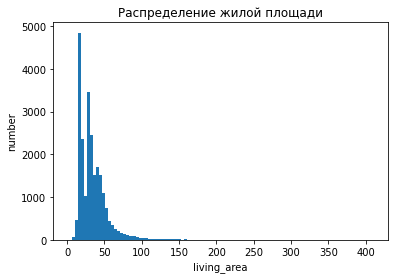

In [22]:
#жилая площадь
print(df['living_area'].sort_values())
print()
print(df['living_area'].describe())
df['living_area'].plot(kind='hist', bins=100)
plt.xlabel('living_area')
plt.ylabel('number')
plt.title('Распределение жилой площади')

Из статистики видим, что в заполненных ячейках большинство значений жилой площади укладывается в диапазон от 0 до 200 кв.м.
Сделаем срез с ограничением по площади и построим гистограмму заново:

Text(0.5, 1.0, 'Распределение жилой площади < 200 кв.м')

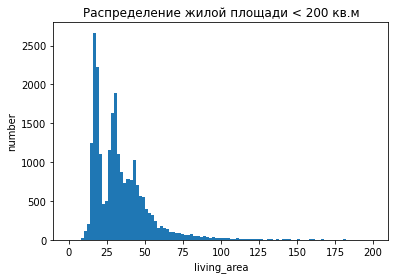

In [23]:
df.query('living_area<200')['living_area'].plot(kind='hist', bins=100, range=(0,200))
plt.xlabel('living_area')
plt.ylabel('number')
plt.title('Распределение жилой площади < 200 кв.м')

Text(0.5, 1.0, 'Распределение площади кухни')

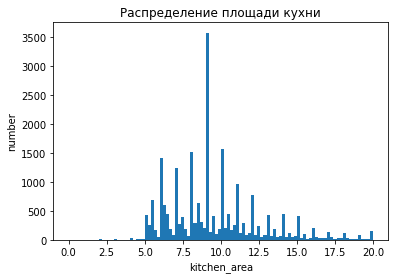

In [24]:
#площадь кухни
df['kitchen_area'].plot(kind='hist', bins=100, range=(0,20))
plt.xlabel('kitchen_area')
plt.ylabel('number')
plt.title('Распределение площади кухни')

count    2.365000e+04
mean     6.541127e+06
std      1.089640e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.799000e+06
max      7.630000e+08
Name: last_price, dtype: float64

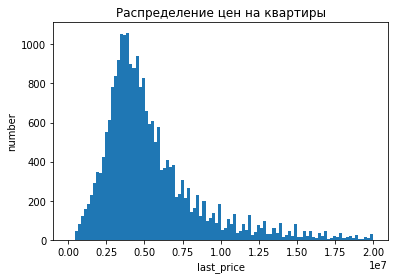

In [25]:
#цена объекта
df['last_price'].plot(kind='hist', bins=100, range = (12190,20000000))
plt.xlabel('last_price')
plt.ylabel('number')
plt.title('Распределение цен на квартиры')
df['last_price'].describe()

Диапазон цен от 12'190 до 17'500'000

count    23650.000000
mean         2.070106
std          1.078620
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

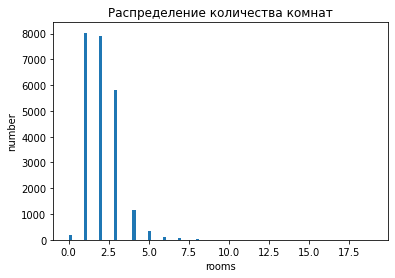

In [26]:
#количество комнат
df['rooms'].plot(kind='hist', bins=100, range=(0,19))
plt.xlabel('rooms')
plt.ylabel('number')
plt.title('Распределение количества комнат')
df['rooms'].describe()

Не будем исключать данные.

In [27]:
display(df['rooms'].value_counts())

1     8036
2     7924
3     5797
4     1175
5      326
0      197
6      105
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

Однокомнатных квартир на рынке больше всего, далее двушки и трешки.

count    23650.000000
mean         2.724311
std          0.989255
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64
1.00       1
1.20       1
1.75       1
2.00      11
2.20       1
          ..
26.00      1
27.00      8
27.50      1
32.00      2
100.00     1
Name: ceiling_height, Length: 183, dtype: int64


Text(0, 0.5, 'Число квартир')

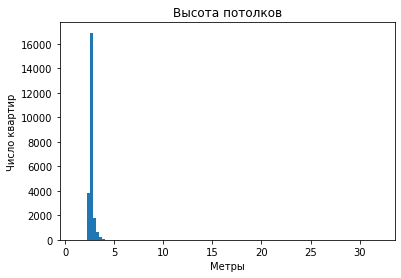

In [28]:
#высота потолков
print(df['ceiling_height'].describe())
print(df['ceiling_height'].value_counts().sort_index())
df['ceiling_height'].plot(kind='hist', bins=100, range=(1,32))
plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Число квартир')

Высота потолка в 100 метров - это аномалия, поэтому это значение заменим на медианное при дальнейшем анализе, а для ошибочных значений, похожих на ошибку в записи числительного, создадим новую колонку.

count    23650.000000
mean         2.720195
std          0.760581
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         32.000000
Name: ceiling_height, dtype: float64


Text(0, 0.5, 'Число квартир')

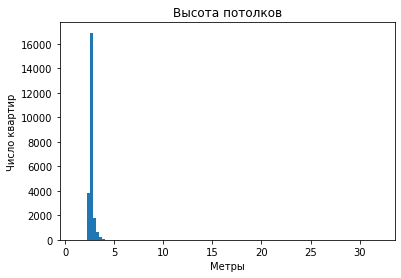

In [29]:
df[df['ceiling_height']==100.0]=df['ceiling_height'].median()
print(df['ceiling_height'].describe())
df['ceiling_height'].plot(kind='hist', bins=100, range=(1,32))
plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Число квартир')

       ceiling_height  ceiling_height_new
0                2.70                2.70
1                2.65                2.65
2                2.65                2.65
3                2.65                2.65
4                3.03                3.03
...               ...                 ...
23694            3.70                3.70
23695            2.65                2.65
23696            2.65                2.65
23697            3.00                3.00
23698            2.50                2.50

[23650 rows x 2 columns]
count    23645.000000
mean         2.697685
std          0.231880
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max          8.300000
Name: ceiling_height_new, dtype: float64


Text(0, 0.5, 'Количество квартир')

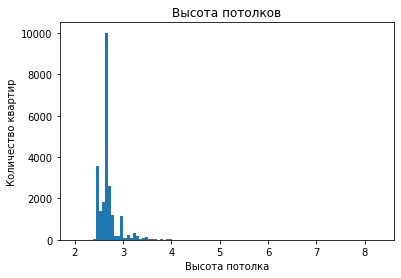

In [30]:
df['ceiling_height_new'] = df['ceiling_height'].apply(lambda x: x/10 if (x > 10) else x)
print(df[['ceiling_height','ceiling_height_new']])    
df.query('ceiling_height_new>=2')['ceiling_height_new']
print(df.query('ceiling_height_new>=2')['ceiling_height_new'].describe())
df.query('ceiling_height_new>=2')['ceiling_height_new'].plot(kind='hist', bins=100, range=(2,8.3))
plt.title('Высота потолков')
plt.xlabel('Высота потолка')
plt.ylabel('Количество квартир')

#тип этажа квартиры («первый», «последний», «другой»)

count      23650
unique         4
top       другой
freq       17326
Name: floor_cat, dtype: object
другой       17326
последний     3411
первый        2912
2.65             1
Name: floor_cat, dtype: int64


Text(0.5, 1.0, 'Распределение квартир по категориям')

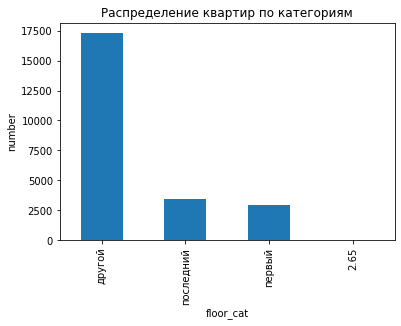

In [31]:
print(df['floor_cat'].describe())
print(df['floor_cat'].value_counts())
df['floor_cat'].value_counts().plot(kind='bar')
plt.xlabel('floor_cat')
plt.ylabel('number')
plt.title('Распределение квартир по категориям')

Первый и последений этажи продают реже остальных.

count    23650.000000
mean        10.673685
std          6.593558
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
1.00       28
2.00      383
2.65        1
3.00      671
4.00     1202
5.00     5778
6.00      919
7.00      593
8.00      396
9.00     3763
10.00    1177
11.00     205
12.00    1367
13.00     232
14.00     555
15.00     368
16.00    1375
17.00     834
18.00     508
19.00     342
20.00     273
21.00     162
22.00     287
23.00     350
24.00     464
25.00    1075
26.00     124
27.00     164
28.00      21
29.00       1
33.00       1
34.00       1
35.00      24
36.00       3
37.00       1
52.00       1
60.00       1
Name: floors_total, dtype: int64


Text(0.5, 1.0, 'Этажность')

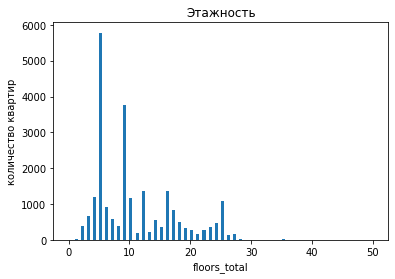

In [32]:
#общее количество этажей в доме
print(df['floors_total'].describe())
print(df['floors_total'].value_counts().sort_index())
df['floors_total'].plot(kind='hist', bins=100, range=(0,50))
plt.xlabel('floors_total')
plt.ylabel('количество квартир')
plt.title('Этажность')

Исключаем записи с 0-м количеством этажей и считаем распределение.

count    23650.000000
mean        10.673685
std          6.593558
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


Text(0.5, 1.0, 'Этажность')

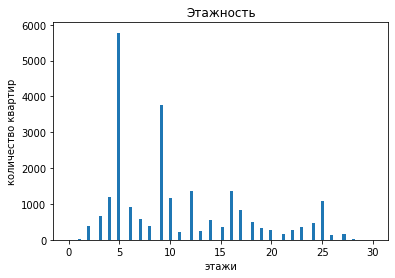

In [33]:
print(df.query('floors_total>0')['floors_total'].describe())
df.query('floors_total>0')['floors_total'].plot(kind='hist', bins=100, range=(0,30))
plt.xlabel('этажи')
plt.ylabel('количество квартир')
plt.title('Этажность')

Дома высотой более 28 этажей и менее 2 продаются реже остальных.

In [34]:
#расстояние до центра города в метрах
print(df['cityCenters_nearest'].describe())
print(df['cityCenters_nearest'].value_counts().sort_index())

count    18139.000000
mean     14197.404248
std       8607.363601
min          2.650000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64
2.65        1
181.00      1
208.00      1
215.00      1
287.00      1
           ..
64857.00    1
65105.00    1
65764.00    1
65952.00    1
65968.00    1
Name: cityCenters_nearest, Length: 7627, dtype: int64


Исключаем записи с 0-м расстоянием до центра города

count    18139.000000
mean     14197.404248
std       8607.363601
min          2.650000
25%       9241.000000
50%      13105.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64


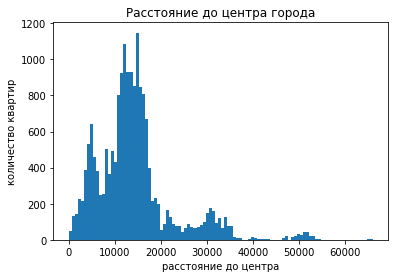

In [35]:
df.query('cityCenters_nearest!=0')['cityCenters_nearest'].plot(kind='hist', bins=100, range=(0,66000))
plt.xlabel('расстояние до центра')
plt.ylabel('количество квартир')
plt.title('Расстояние до центра города')
print(df.query('cityCenters_nearest!=0')['cityCenters_nearest'].describe())

Большая часть продаваемых квартир расположена не далее 20 км от центра города.

count    8064.000000
mean      490.803404
std       342.584540
min         1.000000
25%       288.000000
50%       454.500000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64
1.00       1
2.65       1
3.00       1
4.00       1
7.00       1
          ..
2905.00    1
2984.00    1
3013.00    1
3064.00    1
3190.00    2
Name: parks_nearest, Length: 995, dtype: int64


Text(0.5, 1.0, 'Расстояние до парка')

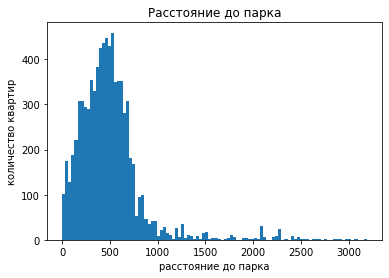

In [36]:
#расстояние до ближайшего парка
print(df['parks_nearest'].describe())
print(df['parks_nearest'].value_counts().sort_index())
df.query('parks_nearest!=0')['parks_nearest'].plot(kind='hist', bins=100, range=(0,3190))
plt.xlabel('расстояние до парка')
plt.ylabel('количество квартир')
plt.title('Расстояние до парка')

Большая часть продаваемых квартир расположена не далее 1 км от парка.

После анализа параметров, изучим, как быстро продавались квартиры:

Среднее количество дней продажи квартиры: 181.0
Медианное количество дней продажи квартиры: 95.0


count    20470.000000
mean       180.752401
std        219.778533
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

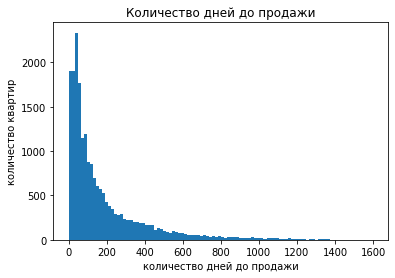

In [37]:
df['days_exposition'].plot(kind='hist', bins=100, range=(0,1600))
plt.xlabel('количество дней до продажи')
plt.ylabel('количество квартир')
plt.title('Количество дней до продажи')
print('Среднее количество дней продажи квартиры:', round(df['days_exposition'].mean(),0))
print('Медианное количество дней продажи квартиры:', df['days_exposition'].median())
df['days_exposition'].describe()

Уменьшим размер корзин, чтобы рассмотреть основную часть данных в диапазоне от 0 до 100 дней

Text(0.5, 1.0, 'Количество дней до продажи')

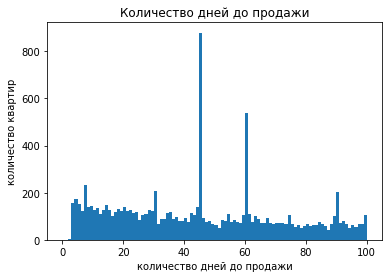

In [38]:
df['days_exposition'].plot(kind='hist', bins=100, range=(0,100))
plt.xlabel('количество дней до продажи')
plt.ylabel('количество квартир')
plt.title('Количество дней до продажи')

Медианное значение времени продажи квартир в 2 раз превышает среднее арифметическое, что говорит о неравномерности распределения продаж. Часть квартир очень долго "висит" в базе на продажу, либо операторы забывают снять квартиру с продажи.
Из гистограммы видно, что активные продажи начинаются с 3 дня и примерно стабильны, но со всплесками на 7, 30, 45, 60, 90 дни. После этого начинается спад. Эти сроки приходятся на конец первой недели, первого месяца, полтора месяца, второго месяца, третьего месяца. Возможно, в эти дни в агентстве недвижимости у риэлторов расчет KPI, поэтому они стараются подвести клиента, или в эти дни у агентства скидки!
Быстрыми продажами можно считать 1-2 дня, а необычно долгими - более 1 года (>400).

Определим влияние параметров квартиры на ее стоимость:
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

Для этого сделаем срез данных с нужными столбцами и построим матрицу корреляции параметров:

In [39]:
df_corr=df[['last_price','total_area','living_area','kitchen_area']]
print(df_corr.sort_values('last_price').corr())

              last_price  total_area  living_area  kitchen_area
last_price      1.000000    0.653797     0.585823      0.440618
total_area      0.653797    1.000000     0.945958      0.569801
living_area     0.585823    0.945958     1.000000      0.411399
kitchen_area    0.440618    0.569801     0.411399      1.000000


Из матрицы видим, что цена (last_price) зависит от (в порядке убывания влияния):
- (1) общей площади (total_area) прямая (увеличивается площадь, увеличивается и цена) и сильная (0.653675),
- (2) жилой площади (living_area) прямая и средняя (0.566492),
- (3) площади кухни (kitchen_area) прямая и средняя (0.519869).

Зависимость от расположения на этаже и количества комнат являются в нашем случае категориальными величинами, будем выяснять связь с ними с помощью графика,
где на оси X будут наши категории этажа, а на оси Y - стоимость квартиры:

Text(0.5, 1.0, 'Этажность ? стоимость')

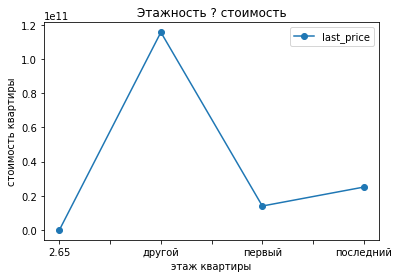

In [40]:
df.pivot_table(index='floor_cat', values='last_price', aggfunc='sum').plot(style='o-')
plt.xlabel('этаж квартиры')
plt.ylabel('стоимость квартиры')
plt.title('Этажность ? стоимость')

Из графика видим, что влияние расположения квартиры на стоимость есть (в порядке убывания влияния):
- (1) другой - самые дорогие квартиры,
- (2) последний,
- (3) первый - самые дешевые квартиры.

Text(0.5, 1.0, 'Количество комнат ? стоимость')

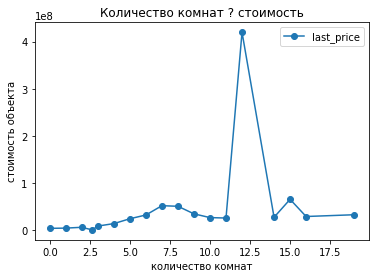

In [41]:
df.pivot_table(index='rooms', values='last_price').plot(style='o-')
plt.xlabel('количество комнат')
plt.ylabel('стоимость объекта')
plt.title('Количество комнат ? стоимость')

График показывает, что есть прямая зависимость стоимости квартиры от количества комнат. Рост не большой, но все же есть. Выброс при количестве комнат от 11 до 14 возможно связан с выкупом комнат в коммуналке для одного хозяина, поэтому цена явно завышена.

Зависимость от даты размещения квартиры также выясним с помощью графика, где на оси X будут дата, месяц и год, а на оси Y - стоимость квартиры:

Text(0.5, 1.0, 'Стоимость ? день недели')

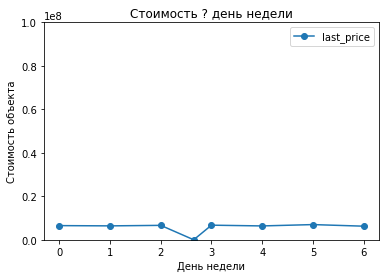

In [42]:
df.pivot_table(index='day', values='last_price').plot(style='o-', ylim=(0, 100000000))
plt.xlabel('День недели')
plt.ylabel('Стоимость объекта')
plt.title('Стоимость ? день недели')

Не стоит размещать объявления в среду, середина недели провальна. Сделаем вывод, что сильной связи между днем недели для размещения и стоимостью объекта нет.

Text(0.5, 1.0, 'Стоимость ? месяц')

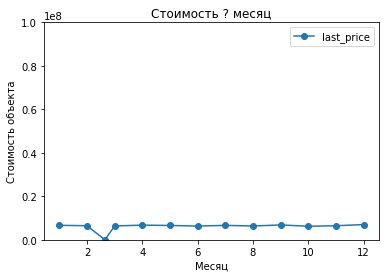

In [43]:
df.pivot_table(index='month', values='last_price').plot(style='o-', ylim=(0,100000000))
plt.xlabel('Месяц')
plt.ylabel('Стоимость объекта')
plt.title('Стоимость ? месяц')

Стоимость приблизительно одинаковая в течение года, так что можно сказать, что связи между стоимостью объекта и месяцем размещения объявления нет. Единственный выпад наблюдается в конце февраля - начале марта. Видимо виноваты праздники.

Text(0.5, 1.0, 'Стоимость ? год')

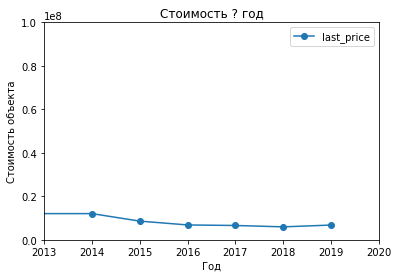

In [44]:
df.pivot_table(index='year', values='last_price').plot(style='o-', xlim=(2013,2020), ylim=(0,100000000))
plt.xlabel('Год')
plt.ylabel('Стоимость объекта')
plt.title('Стоимость ? год')

Самая низкая стоимость была в объявлениях, размещаемых в 2018 году.

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, для этого
построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.

In [45]:
(df.pivot_table(index='locality_name_new', values='sq_m_price', aggfunc=('count', 'mean'))
  .sort_values(by='count', ascending=False).head(10))

,count,mean
locality_name_new,,
Санкт-Петербург,15720,114818.146771
поселок Мурино,556,85681.762572
поселок Шушары,440,78677.364318
Всеволожск,398,68654.473970
Пушкин,369,103125.819377
Колпино,338,75424.579112
поселок Парголово,327,90175.913089
Гатчина,307,68746.146515
деревня Кудрово,299,92473.547559


Видим, что на первом месте оказался Санкт-Петербург (ожидаемо), на 10-м месте находится Выборг. Стоимость 1 кв.м. 10-го места в 2 раза меньше, чем 1-го.

Теперь выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра.

Text(0.5, 1.0, 'Стоимость объекта ? расстояние до центра')

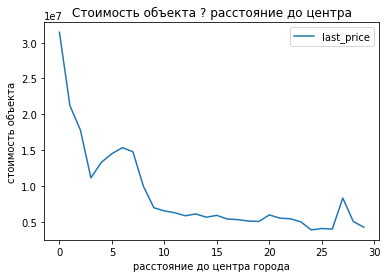

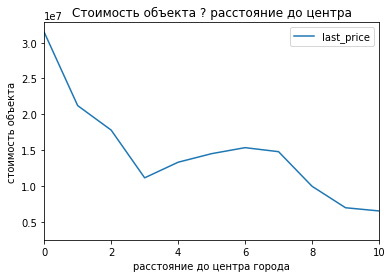

In [46]:
(df.query('locality_name_new=="Санкт-Петербург"')
   .pivot_table(index='cityCenters_nearest_km',
             values='last_price',
             aggfunc=('mean')).sort_index()
)
(df.query('locality_name_new=="Санкт-Петербург"')
   .pivot_table(index='cityCenters_nearest_km',
             values='last_price',
             aggfunc=('mean')).plot()
)
#укрупним отрезок от 0 до 10, чтобы рассмотреть выброс
plt.xlabel('расстояние до центра города')
plt.ylabel('стоимость объекта')
plt.title('Стоимость объекта ? расстояние до центра')
(df.query('locality_name_new=="Санкт-Петербург"')
   .pivot_table(index='cityCenters_nearest_km',
             values='last_price',
             aggfunc=('mean')).plot(xlim=(0,10))
)
plt.xlabel('расстояние до центра города')
plt.ylabel('стоимость объекта')
plt.title('Стоимость объекта ? расстояние до центра')

График подтверждает, что в целом при удалении от центра города стоимость квартир уменьшается. При удаленности квартиры от центра на растояние от 3 до 8 км наблюдается небольшая стагнация стоимости, то есть для людей это уже равноудаленно от центра, а потом падение продолжается. Ситуация повторяется при больших значениях удаленности. То есть расстояние людьми воспринимается не дискретно, а интервалами.

### Общий вывод

В представленных данных обнаружились следующие недостатки:
- пропуски в значимых полях, которые влияют на стоимость квартиры: высота потолков, жилая площадь, площадь кухни, стоимость квартиры, этаж;
- разные записи в столбце населенных пунктов для одинаковых населенных пунктов и пропущенные значения, что не позволит отобрать квартиру по фильтру на населенный пункт;
- ошибочные записи в высоте потолков.

Проведенный анализ данных позволил определить следующие факторы влияния на стоимость квартиры:
- параметры квартиры: общая площадь, жилая площадь, площадь кухни и количество комнат прямо влияют на стоимость квартиры;
- этаж, на котором располагается квартиры (самые дешевые на первом, последнем этажах),
- дата размещения объявления о продаже имеет очень слабое влияние на ее стоимость.

Самые дорогие квартиры оказались в Санкт-Петербурге, 10-ку самых дорогих мест замыкает Выборг.